<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: COVID-19 Dashboard
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Introdução;</li>
  <li>Análise Exploratória de Dados;</li>
  <li>Visualização Interativa de Dados;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados interativa. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/) e seu *dashboard* [Google Data Studio](https://datastudio.google.com/).

---

# **COVID Dashboard**

## 1\. Contexto

Vamos analisar a questao do COVID-19 no estado de Goiás no Brasil, analisando o numero de casos, numero de mortes, as tendencias de casos e mortes e media movel os ultimos 7 dias em  2021, e a partir dessas análises chegar a conclusão se os numeros cresceram ou declinaram com o passar dos meses.

## 2\. Pacotes e bibliotecas

In [46]:
import math
from typing import Iterator
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

## 3\. Extração

In [71]:
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-12-2021.csv', sep=',')

In [72]:
def date_range(start_date: datetime, end_date: datetime) -> Iterator[datetime]:
  date_range_days: int = (end_date - start_date).days
  for lag in range(date_range_days):
    yield start_date + timedelta(lag)

start_date = datetime(2021,  1,  1)
end_date   = datetime(2021, 12, 31)

In [73]:
cases = None
cases_is_empty = True

for date in date_range(start_date=start_date, end_date=end_date):

  date_str = date.strftime('%m-%d-%Y')
  data_source_url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{date_str}.csv'

  case = pd.read_csv(data_source_url, sep=',')

  case = case.drop(['FIPS', 'Admin2', 'Last_Update', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Case_Fatality_Ratio'], axis=1)
  case = case.query('Country_Region == "Brazil" and Province_State == "Goias"').reset_index(drop=True)
  case['Date'] = pd.to_datetime(date.strftime('%Y-%m-%d'))
  if cases_is_empty:
    cases = case
    cases_is_empty = False
  else:
    cases = pd.concat([cases, case], axis= 0, ignore_index=True)

## 4\. Transformação

In [74]:
cases.head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
0,Goias,Brazil,309191,6805,4404.337541,2021-01-01
1,Goias,Brazil,309320,6805,4405.505906,2021-01-02
2,Goias,Brazil,309454,6805,4407.600415,2021-01-03
3,Goias,Brazil,311067,6857,4416.648120,2021-01-04
4,Goias,Brazil,312124,6898,4439.174769,2021-01-05


In [75]:
cases.shape

(364, 6)

In [76]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province_State  364 non-null    object        
 1   Country_Region  364 non-null    object        
 2   Confirmed       364 non-null    int64         
 3   Deaths          364 non-null    int64         
 4   Incident_Rate   364 non-null    float64       
 5   Date            364 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 17.2+ KB


In [77]:
cases = cases.rename(
  columns={
    'Province_State': 'State',
    'Country_Region': 'Country'
  }
)

for col in cases.columns:
  cases = cases.rename(columns={col: col.lower()})

In [78]:
states_map = {
    'Goias': 'Goiás',
}

cases['state'] = cases['state'].apply(lambda state: states_map.get(state) if state in states_map.keys() else state)

In [79]:
cases.head()

,state,country,confirmed,deaths,incident_rate,date
0,Goiás,Brazil,309191,6805,4404.337541,2021-01-01
1,Goiás,Brazil,309320,6805,4405.505906,2021-01-02
2,Goiás,Brazil,309454,6805,4407.600415,2021-01-03
3,Goiás,Brazil,311067,6857,4416.648120,2021-01-04
4,Goiás,Brazil,312124,6898,4439.174769,2021-01-05


Análise: Visualizar a evolução diária dos casos confirmados e das mortes ao longo do tempo. Isso ajudará a identificar picos e quedas no número de casos.

Método: Criar gráficos de linha para o número de casos confirmados e mortes por dia.

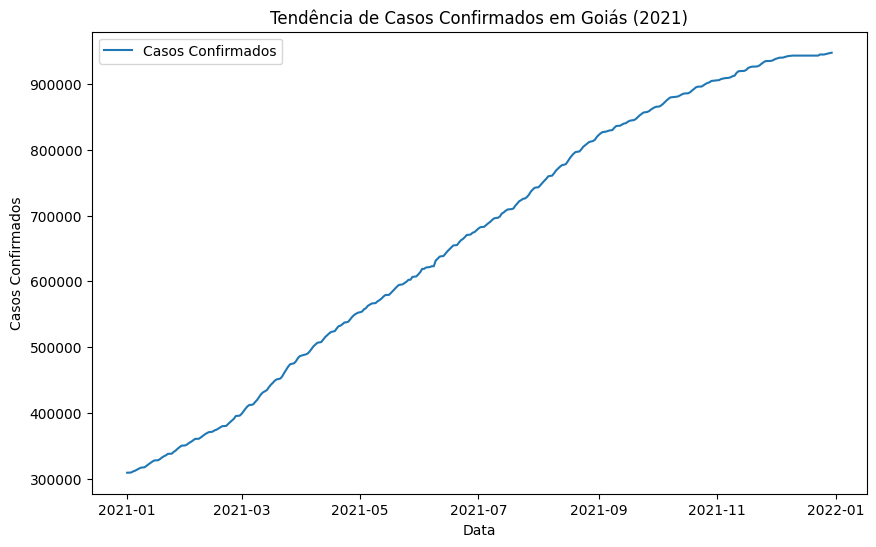

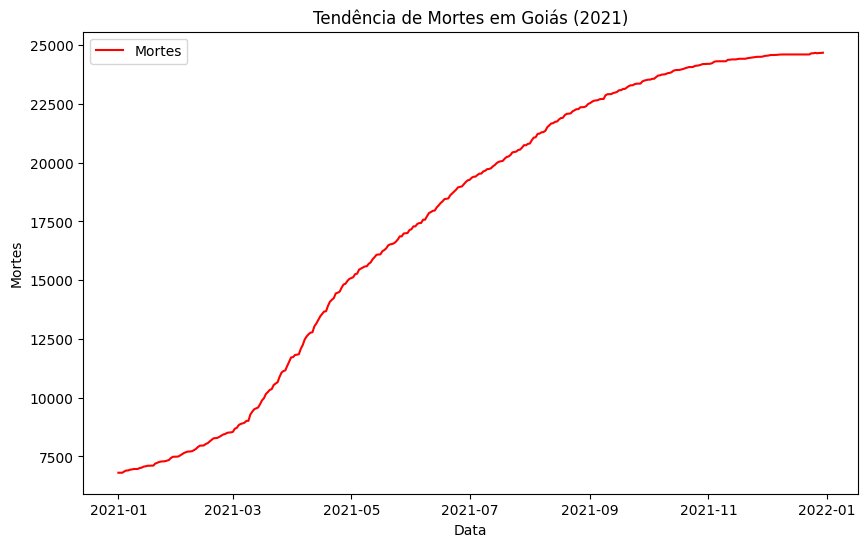

In [80]:
import matplotlib.pyplot as plt

# Agrupando por data
grouped = cases.groupby('date').sum()

# Gráfico de casos confirmados
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped['confirmed'], label='Casos Confirmados')
plt.xlabel('Data')
plt.ylabel('Casos Confirmados')
plt.title('Tendência de Casos Confirmados em Goiás (2021)')
plt.legend()
plt.show()

# Gráfico de mortes
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped['deaths'], label='Mortes', color='red')
plt.xlabel('Data')
plt.ylabel('Mortes')
plt.title('Tendência de Mortes em Goiás (2021)')
plt.legend()
plt.show()

Análise: Calcular a taxa de letalidade (relação entre mortes e casos confirmados) ao longo do tempo.

Método: Dividir o número de mortes pelo número de casos confirmados para obter a taxa de letalidade diária.

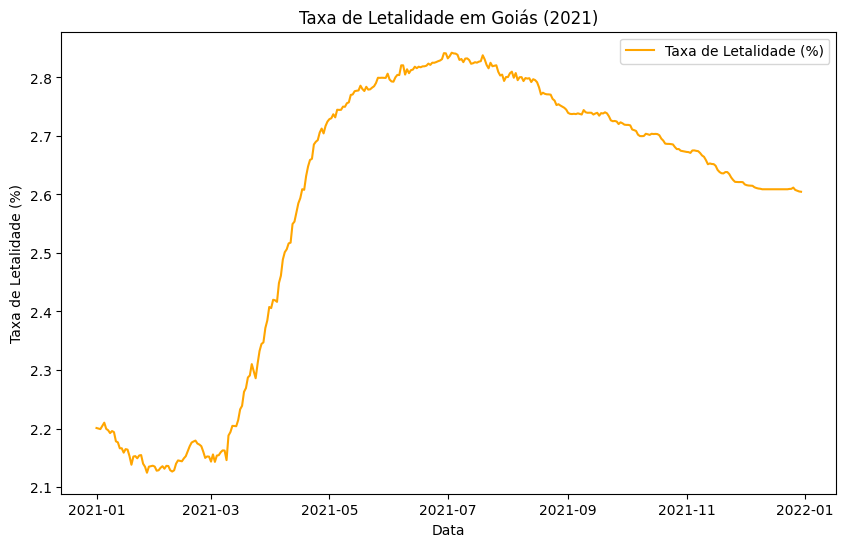

In [81]:
# Cria uma cópia do DataFrame original
cases_copy = cases.copy()

# Calcula a coluna 'Letalidade' na cópia do DataFrame
cases_copy['Letalidade'] = cases_copy['deaths'] / cases_copy['confirmed'] * 100

# Gráfico da letalidade usando a cópia do DataFrame
plt.figure(figsize=(10, 6))
plt.plot(cases_copy['date'], cases_copy['Letalidade'], label='Taxa de Letalidade (%)', color='orange')
plt.xlabel('Data')
plt.ylabel('Taxa de Letalidade (%)')
plt.title('Taxa de Letalidade em Goiás (2021)')
plt.legend()
plt.show()



Análise: Calcular a taxa de crescimento diário dos casos confirmados e mortes para avaliar se o número de infecções estava aumentando ou diminuindo ao longo do tempo.

Método: Calcular a taxa de crescimento percentual usando a diferença entre dias consecutivos.

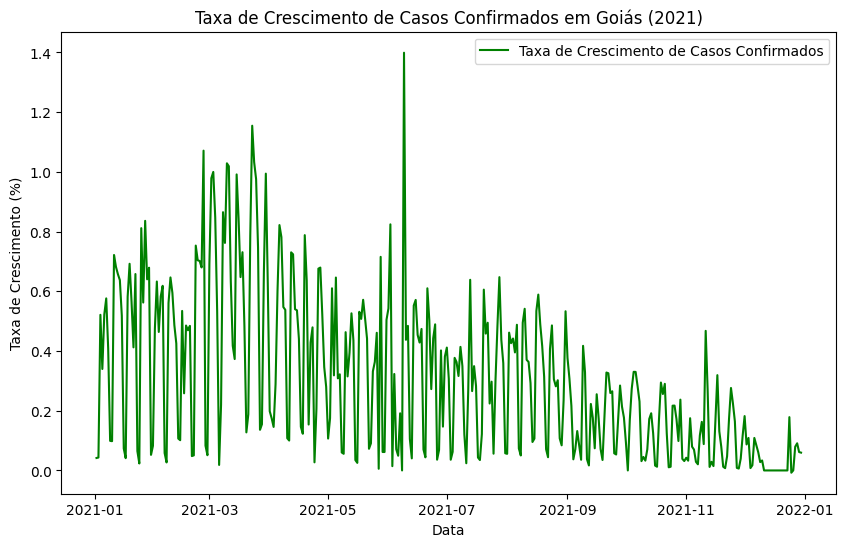

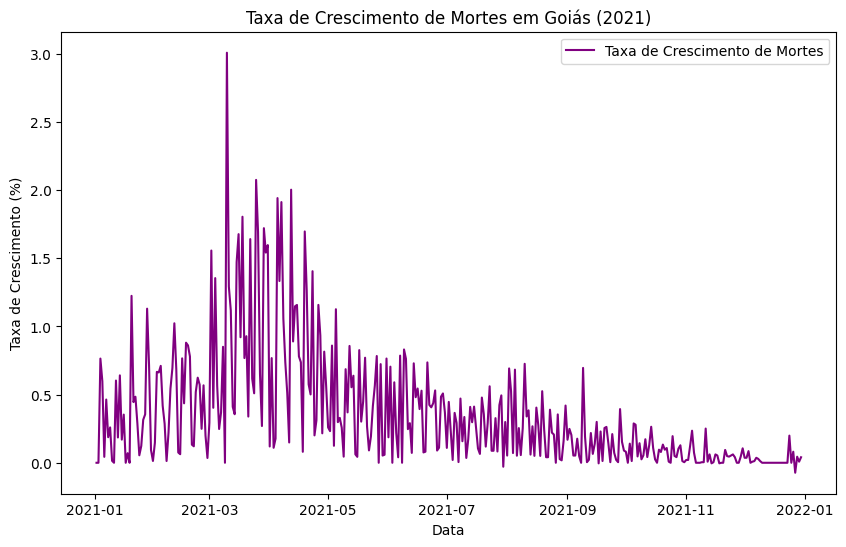

In [82]:
cases['Crescimento_Confirmados'] = cases['confirmed'].pct_change() * 100
cases['Crescimento_Mortes'] = cases['deaths'].pct_change() * 100

# Gráfico de taxa de crescimento de casos confirmados
plt.figure(figsize=(10, 6))
plt.plot(cases['date'], cases['Crescimento_Confirmados'], label='Taxa de Crescimento de Casos Confirmados', color='green')
plt.xlabel('Data')
plt.ylabel('Taxa de Crescimento (%)')
plt.title('Taxa de Crescimento de Casos Confirmados em Goiás (2021)')
plt.legend()
plt.show()

# Gráfico de taxa de crescimento de mortes
plt.figure(figsize=(10, 6))
plt.plot(cases['date'], cases['Crescimento_Mortes'], label='Taxa de Crescimento de Mortes', color='purple')
plt.xlabel('Data')
plt.ylabel('Taxa de Crescimento (%)')
plt.title('Taxa de Crescimento de Mortes em Goiás (2021)')
plt.legend()
plt.show()


In [83]:
cases['month'] = cases['date'].apply(lambda date: date.strftime('%Y-%m'))
cases['year']  = cases['date'].apply(lambda date: date.strftime('%Y'))

In [84]:
cases['population'] = round(100000 * (cases['confirmed'] / cases['incident_rate']))
cases = cases.drop('incident_rate', axis=1)

In [85]:
cases_ = None
cases_is_empty = True

def get_trend(rate: float) -> str:

  if np.isnan(rate):
    return np.NaN

  if rate < 0.75:    # Se a divisão for menor que 0.75 (correção 0.85)
    status = 'downward'
  elif rate > 1.15:
    status = 'upward'
  else:
    status = 'stable'

  return status


for state in cases['state'].drop_duplicates():

  cases_per_state = cases.query(f'state == "{state}"').reset_index(drop=True)
  cases_per_state = cases_per_state.sort_values(by=['date'])

  cases_per_state['confirmed_1d'] = cases_per_state['confirmed'].diff(periods=1)
  cases_per_state['confirmed_moving_avg_7d'] = np.ceil(cases_per_state['confirmed_1d'].rolling(window=7).mean())
  cases_per_state['confirmed_moving_avg_7d_rate_14d'] = cases_per_state['confirmed_moving_avg_7d']/cases_per_state['confirmed_moving_avg_7d'].shift(periods=14)
  cases_per_state['confirmed_trend'] = cases_per_state['confirmed_moving_avg_7d_rate_14d'].apply(get_trend)

  cases_per_state['deaths_1d'] = cases_per_state['deaths'].diff(periods=1)
  cases_per_state['deaths_moving_avg_7d'] = np.ceil(cases_per_state['deaths_1d'].rolling(window=7).mean())
  cases_per_state['deaths_moving_avg_7d_rate_14d'] = cases_per_state['deaths_moving_avg_7d']/cases_per_state['deaths_moving_avg_7d'].shift(periods=14)
  cases_per_state['deaths_trend'] = cases_per_state['deaths_moving_avg_7d_rate_14d'].apply(get_trend)

  if cases_is_empty:
    cases_ = cases_per_state
    cases_is_empty = False
  else:
    cases_ = pd.concat([cases_, cases_per_state],axis=0, ignore_index=True)

cases = cases_
cases_ = None

In [86]:
cases['population'] = cases['population'].astype('Int64')
cases['confirmed_1d'] = cases['confirmed_1d'].astype('Int64')
cases['confirmed_moving_avg_7d'] = cases['confirmed_moving_avg_7d'].astype('Int64')
cases['deaths_1d'] = cases['deaths_1d'].astype('Int64')
cases['deaths_moving_avg_7d'] = cases['deaths_moving_avg_7d'].astype('Int64')

Por fim, vamos reorganizar as colunas e conferir o resultado final.

In [87]:
cases = cases[['date', 'country', 'state', 'population', 'confirmed', 'confirmed_1d', 'confirmed_moving_avg_7d', 'confirmed_moving_avg_7d_rate_14d', 'confirmed_trend', 'deaths', 'deaths_1d', 'deaths_moving_avg_7d', 'deaths_moving_avg_7d_rate_14d', 'deaths_trend', 'month', 'year']]

In [ ]:
cases.head(n=25)

,date,country,state,population,confirmed,confirmed_1d,confirmed_moving_avg_7d,confirmed_moving_avg_7d_rate_14d,confirmed_trend,deaths,deaths_1d,deaths_moving_avg_7d,deaths_moving_avg_7d_rate_14d,deaths_trend,month,year
0,2021-01-01,Brazil,Goiás,7020148,309191,<NA>,<NA>,NaN,NaN,6805,<NA>,<NA>,NaN,NaN,2021-01,2021
1,2021-01-02,Brazil,Goiás,7021214,309320,129,<NA>,NaN,NaN,6805,0,<NA>,NaN,NaN,2021-01,2021
2,2021-01-03,Brazil,Goiás,7020918,309454,134,<NA>,NaN,NaN,6805,0,<NA>,NaN,NaN,2021-01,2021
3,2021-01-04,Brazil,Goiás,7043056,311067,1613,<NA>,NaN,NaN,6857,52,<NA>,NaN,NaN,2021-01,2021
4,2021-01-05,Brazil,Goiás,7031127,312124,1057,<NA>,NaN,NaN,6898,41,<NA>,NaN,NaN,2021-01,2021
5,2021-01-06,Brazil,Goiás,7025430,313755,1631,<NA>,NaN,NaN,6901,3,<NA>,NaN,NaN,2021-01,2021
6,2021-01-07,Brazil,Goiás,7042837,315563,1808,<NA>,NaN,NaN,6933,32,<NA>,NaN,NaN,2021-01,2021
7,2021-01-08,Brazil,Goiás,7032892,316852,1289,1095,NaN,NaN,6946,13,21,NaN,NaN,2021-01,2021
8,2021-01-09,Brazil,Goiás,7021498,317166,314,1121,NaN,NaN,6964,18,23,NaN,NaN,2021-01,2021
9,2021-01-10,Brazil,Goiás,7021782,317477,311,1147,NaN,NaN,6965,1,23,NaN,NaN,2021-01,2021


## 5\. Carregamento

In [ ]:
cases.to_csv('./covid-cases-goias.csv', sep=',', index=False)

Com a análise chegando ai fim percebemos que o numero de casos e de mortes no estado de Goias em dezembro esta menor do que registrado no inicio de 2021, onde a partir de Maio percebe-se claramente essa queda continua do numero de casos.